In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
prediction_path = '/root/autodl-tmp/cervical_spine/predictions/predictions-135654-baseline.csv'

In [3]:
columns = ['UID'] + [f'P{i}' for i in range(8)] + ['loss','loss_pos','loss_neg'] + [f'C{i}' for i in range(8)] 
patient_pred_df = pd.read_csv(prediction_path, names=columns)

patient_pred_df

,UID,P0,P1,P2,P3,P4,P5,P6,P7,loss,loss_pos,loss_neg,C0,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.118095,0.021837,0.118095,0.010000,0.010000,0.022779,0.096245,0.034210,0.086185,0.000000,0.086185,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0.861524,0.065945,0.349547,0.220693,0.051669,0.077675,0.861524,0.481717,1.239662,0.000000,1.239662,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0.972806,0.020543,0.031558,0.029285,0.288865,0.972806,0.096592,0.035705,2.099969,0.000000,2.099969,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,0.824715,0.016137,0.353298,0.026176,0.010734,0.824715,0.230183,0.781418,0.379821,0.298683,0.596187,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0.489932,0.025880,0.035676,0.052219,0.329726,0.051224,0.489932,0.185163,0.439950,0.000000,0.439950,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1.2.826.0.1.3680043.9926,0.991444,0.022984,0.991444,0.050786,0.061365,0.078122,0.060240,0.040134,0.020937,0.008593,0.053856,1,0,1,0,0,0,0,0
2008,1.2.826.0.1.3680043.9940,0.999000,0.010000,0.047091,0.997550,0.999000,0.021708,0.020056,0.019353,0.599391,0.426454,1.221967,1,0,0,0,1,1,0,0
2009,1.2.826.0.1.3680043.9994,0.616980,0.060509,0.061162,0.021689,0.051544,0.038704,0.077021,0.616980,0.571240,0.000000,0.571240,0,0,0,0,0,0,0,0
2010,1.2.826.0.1.3680043.9996,0.569951,0.249763,0.569951,0.014309,0.076402,0.062535,0.330419,0.028706,0.448697,0.562204,0.146010,1,0,1,0,0,0,0,0


In [4]:
# patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
# label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# # patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

# label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
# patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
# patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
# patient_pred_df

In [5]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [6]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [7]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.41178339428737526


min loss: 0.41153094247253114


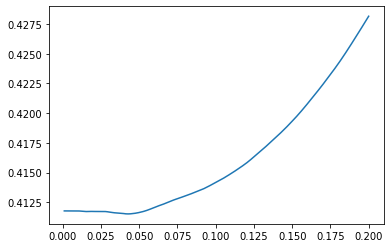

In [8]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.4107036224797446


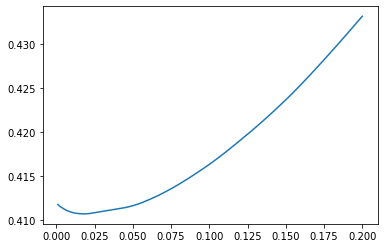

In [9]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

In [10]:
# clip both
losses = []

min_clips = np.linspace(0.001, 0.2, 200)
max_clips = np.linspace(0.001, 0.2, 200)

for min_clip in tqdm(min_clips):
    
    for max_clip in max_clips:
        new_prob = np.clip(prob, a_min=min_clip, a_max=1-max_clip)
        loss= cal_loss(new_prob, label)
    
        losses.append(loss)
print('min loss:', np.min(losses))
# plt.plot(clips, losses)

100%|██████████| 200/200 [00:12<00:00, 16.51it/s]

min loss: 0.4104513212596615
